<a href="https://colab.research.google.com/github/himanshu-skid19/Unconditional-Image-Generation-Using-a-Diffusion-model/blob/master/Unconditional_Image_Generation_Using_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

In [2]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

In [3]:
def show_images(dataset, num_samples=20, cols = 3):
  plt.figure(figsize=(15,15))
  for i, img in enumerate(data):
    if i == num_samples:
      break
    plt.subplot(int(num_samples/cols+1), cols, i+1)
    plt.imshow(img['image'])


In [4]:
from datasets import load_dataset, Image, Dataset

data = load_dataset("nelorth/oxford-flowers", split="train")
data

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 7169
})

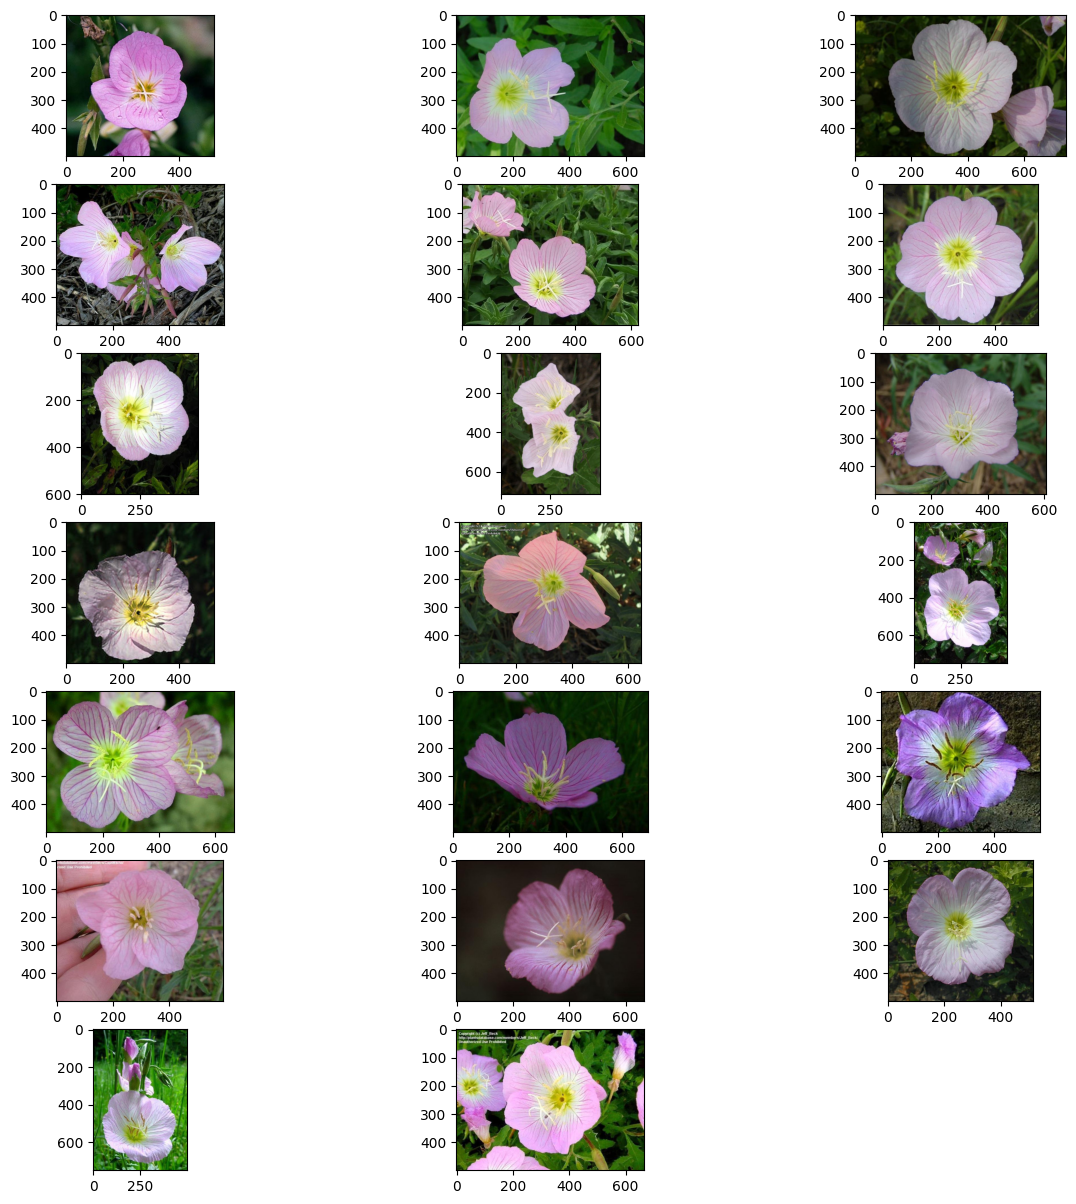

In [5]:
show_images(data)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize

img_size = 128
transform = Compose([
        Resize([img_size, img_size]),
        CenterCrop(img_size),
        ToTensor(),
])

In [8]:
data_tensor = transform(data[0]["image"]).unsqueeze_(0).to(device)

for i in tqdm(range(1, 3000)):
  x = transform(data[i]["image"]).unsqueeze_(0).to(device)
  data_tensor = torch.cat((data_tensor, x))

data_tensor.shape

  0%|          | 0/2999 [00:00<?, ?it/s]

torch.Size([3000, 3, 128, 128])

In [10]:
data_loader = torch.utils.data.DataLoader(dataset = data_tensor, batch_size=64, shuffle = True, drop_last  =True)
data_loader

In [11]:
dataiter = iter(data_loader)
images = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [12]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
timesteps= 300
betas = linear_beta_schedule(timesteps=timesteps)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [41]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [42]:
image = next(iter(data_loader))[0]

for idx in range(0, timesteps):
  if idx == 2:
    break;
  t = torch.Tensor([idx]).type(torch.int64)
  img, noise = forward_diffusion_sample(image, t)
  print(img.shape)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


<ipython-input-43-a82e53f1f37c>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int((idx/stepsize)) + 1)


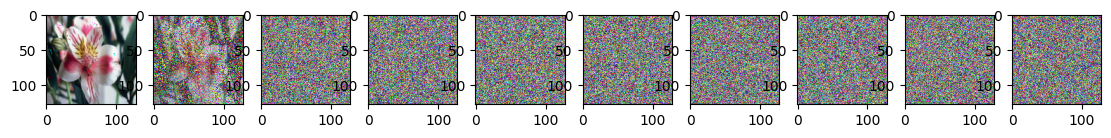

In [43]:
import numpy as np
image = next(iter(data_loader))[0]

plt.figure(figsize = (15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(0, timesteps, stepsize):
  t = torch.Tensor([idx]).type(torch.int64)
  plt.subplot(1, num_images+1, int((idx/stepsize)) + 1)
  image, noise = forward_diffusion_sample(image, t)
  show_tensor_image(image)

In [68]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
            self.maxpool = nn.MaxPool2d(4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            self.Upsample = nn.Upsample(scale_factor = 2, mode ='bilinear')
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.silu  = nn.SiLU()
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = (self.silu(self.bnorm1(self.conv1(x))))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = (self.silu(self.bnorm2(self.conv2(h))))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (32, 64, 128, 256, 512)
        up_channels = (512, 256, 128, 64, 32)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  15639811


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (Upsample): Upsample(scale_factor=2.0, mode='bilinear')
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(6

In [69]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)


In [70]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(timesteps/num_images)

    for i in range(0,timesteps)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [71]:
torch.cuda.empty_cache()

In [72]:
for step, batch in enumerate(data_loader):
    if step == 2:
      break
    print(batch.shape)


torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


In [73]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5 # Try more!
BATCH_SIZE = 64
for epoch in tqdm(range(epochs)):
    for step, batch in tqdm(enumerate(data_loader)):
      optimizer.zero_grad()

      t = torch.randint(0, timesteps, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch, t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

AttributeError: ignored

In [35]:
def extract(a, t, x_shape):
  batch_size = t.shape[0]
  out = a.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(device)

In [36]:
# extract(betas, torch.full((64,),69 , device=device, dtype=torch.long), [3,128,128])

In [37]:
torch.full((64,), 2, device=device, dtype=torch.long)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [38]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), 3)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [47]:
samples = sample(model, image_size=img_size, batch_size=64, channels=3)

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

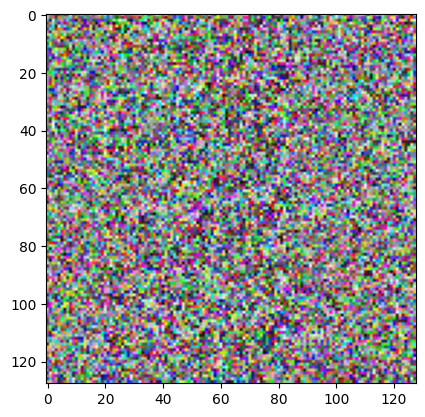

In [57]:
random_index = 5
img  = transforms.Lambda(lambda t: t.permute((2,1,0)))(torch.Tensor(samples[-1][random_index].reshape(img_size, img_size, 3)))
show_tensor_image(img)

In [ ]:
# img_size = 128
# transform = Compose([
#         Resize([img_size, img_size]),
#         CenterCrop(img_size),
#         ToTensor(),
# ])

In [ ]:
show_tensor_image(samples[-1][random_index].reshape(img_size, img_size, 3))

AttributeError: ignored

In [ ]:
filename = "trained_model.sav"
pickle.dump(model, open(filename, 'wb'))

In [ ]:
torch.save(model.state_dict(), "/content/")
